# # Project: NLP to Analyze Sentiments of Consumer Reviews of Hotels    

In this project, we use Sentiment Analysis of NLP to analyze reviews of hotels. We would like to understand if a review is positive or negative (without looking at the ratings). We will use the following libraries:
- NLTK: the most famous python module for NLP techniques
- Gensim: an open-source library for unsupervised topic modeling and NLP, using statistical machine learning
- Scikit-learn: the most used python machine learning library

The dataset is from Kaggle and contains 515,000 customer reviews and scoring of 1493 luxury hotels offered in Booking.come across Europe.
The dataset can be found here: https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe/version/1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Part 1: Load and Select the Data 

In [18]:
# load the data into a datadrame
reviews = pd.read_csv('/Users/Amir/PythonProjects/HotelRRDataset/Hotel_Reviews.csv')
reviews.info()

# append positive and negative reviews to have all in one column (in booking, there is two entires for 
# consumers to write positive and negative comments)
reviews["Review"] = reviews["Negative_Review"] + reviews["Positive_Review"]

# we define a bad review as the one which has overall rating of lower than 5. We label them using actual ratings 
# to compare them to our predicion to evaluate the performance 
reviews["Bad_Review?"] = reviews["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
Hotel_Address                                 515738 non-null object
Additional_Number_of_Scoring                  515738 non-null int64
Review_Date                                   515738 non-null object
Average_Score                                 515738 non-null float64
Hotel_Name                                    515738 non-null object
Reviewer_Nationality                          515738 non-null object
Negative_Review                               515738 non-null object
Review_Total_Negative_Word_Counts             515738 non-null int64
Total_Number_of_Reviews                       515738 non-null int64
Positive_Review                               515738 non-null object
Review_Total_Positive_Word_Counts             515738 non-null int64
Total_Number_of_Reviews_Reviewer_Has_Given    515738 non-null int64
Reviewer_Score                                515738 non-null flo

In [19]:
# Select only the relevant data for Sentiment Analysis
reviews_SA = reviews[["Review","Bad_Review?"]]
reviews_SA.head(10)

,Review,Bad_Review?
0,I am so angry that i made this post available...,1
1,No Negative No real complaints the hotel was g...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,1
4,You When I booked with your company on line y...,0
5,Backyard of the hotel is total mess shouldn t...,0
6,Cleaner did not change our sheet and duvet ev...,1
7,Apart from the price for the brekfast Everyth...,0
8,Even though the pictures show very clean room...,0
9,The aircondition makes so much noise and its ...,0


In [20]:
# Sample some data to increase the computation speed
# sample 10% of the data 
reviews_SA = reviews_SA.sample(frac = 0.1, replace = False, random_state=42)

In [21]:
# Clean-up
# based on the data spec, if the reviewer does not give the negative or positive review, 
# the associated column will 'No Negative' and 'No Positive'. We need to remove them
# ro turn off the chain warning 
pd.options.mode.chained_assignment = None
reviews_SA["Review"] = reviews_SA["Review"].apply(lambda x: x.replace('No Negative','').replace('No Positive',''))
# see row two for an example 
reviews_SA.head(10)

,Review,Bad_Review?
488440,Would have appreciated a shop in the hotel th...,0
274649,No tissue paper box was present at the room,0
374688,Pillows Nice welcoming and service,0
404352,Everything including the nice upgrade The Hot...,0
451596,Lovely hotel v welcoming staff,0
302161,They don t have free wifi The location is per...,0
317079,Room generally a bit shabby with some lack of...,0
13963,Executive rooms 9th Floor don t have a bath T...,0
159785,Pity about the two days of rain Its centralit...,0
195089,Didn t like it at all construction was in pro...,1


## Part 2: Text Preprocessing
Since, text is the most unstructured form of all the available data, various types of noise are present in it and the data is not readily analyzable without any pre-processing. The entire process of cleaning and standardization of text, making it noise-free and ready for analysis is known as text preprocessing.

In [22]:
# Import required libraries 
import nltk
# FOR THE FIRST TIME, RUN ALL ABOVE CODE TO MAKE SURE YOU HAVE NECCESSARY NLTK MODULES
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

## Part 2A: Lower the Text

In [23]:
# lower text
def text_low(text):
    text = text.lower()
    return text 
reviews_SA["Review_clean"] = reviews_SA["Review"].apply(lambda x: text_low(x))
reviews_SA.head(3)

,Review,Bad_Review?,Review_clean
488440,Would have appreciated a shop in the hotel th...,0,would have appreciated a shop in the hotel th...
274649,No tissue paper box was present at the room,0,no tissue paper box was present at the room
374688,Pillows Nice welcoming and service,0,pillows nice welcoming and service


## Part 2B: Tokenize
Tokenize the text (split the text into words) and remove the punctuation

In [24]:
# tokenize text and remove puncutation
from nltk.tokenize import WhitespaceTokenizer
import string
def text_tok(text):
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    return text

reviews_SA["Review_clean"] = reviews_SA["Review_clean"].apply(lambda x: text_tok(x))
reviews_SA.head(3)


,Review,Bad_Review?,Review_clean
488440,Would have appreciated a shop in the hotel th...,0,"[, would, have, appreciated, a, shop, in, the,..."
274649,No tissue paper box was present at the room,0,"[, no, tissue, paper, box, was, present, at, t..."
374688,Pillows Nice welcoming and service,0,"[, pillows, , nice, welcoming, and, service]"


## Part 2C: Noise Removal
Remove all common words, stopwords, numbers, etc. 

In [25]:
from nltk.corpus import stopwords
def text_noise(text):
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove useless stop words like 'the', 'a' ,'this' etc.
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    return text 

reviews_SA["Review_clean"] = reviews_SA["Review_clean"].apply(lambda x: text_noise(x))
reviews_SA.head(3)

,Review,Bad_Review?,Review_clean
488440,Would have appreciated a shop in the hotel th...,0,"[would, appreciated, shop, hotel, sold, drinki..."
274649,No tissue paper box was present at the room,0,"[tissue, paper, box, present, room]"
374688,Pillows Nice welcoming and service,0,"[pillows, nice, welcoming, service]"


## Part 2D: POS Tagging
Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database.In WordNet lexical database, Nouns, verbs, adjectives and adverbs are grouped.

In [26]:
from nltk import pos_tag
def text_pos(text):
    text = pos_tag(text)
    return text
reviews_SA["Review_clean"] = reviews_SA["Review_clean"].apply(lambda x: text_pos(x))
reviews_SA.head(3)

,Review,Bad_Review?,Review_clean
488440,Would have appreciated a shop in the hotel th...,0,"[(would, MD), (appreciated, VBD), (shop, VB), ..."
274649,No tissue paper box was present at the room,0,"[(tissue, NN), (paper, NN), (box, NN), (presen..."
374688,Pillows Nice welcoming and service,0,"[(pillows, NNS), (nice, JJ), (welcoming, VBG),..."


## Part 2E: Lemmatize 
Lemmatization is an organized & step by step procedure of obtaining the root form of the word (e.g. rooms -> room, slept -> sleep). It makes use of vocabulary (dictionary importance of words) and morphological analysis (word structure and grammar relations).

Note: The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming is a rudimentary rule-based process of stripping the suffixesjust which removes the last few characters, often leading to incorrect meanings and spelling errors.
‘Caring’ -> Lemmatization -> ‘Care’
‘Caring’ -> Stemming -> ‘Car

Good tutorial of lemmatization in Python using different libraries and methodes: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

In [27]:
# WordNet® is a large lexical database of English.
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# We need to map NLTK’s POS tags to the format wordnet lemmatizer would accept. 
# The get_wordnet_pos() function defined below does this mapping job.
def get_wordnet_pos(t):
    if t.startswith('J'):
        return wordnet.ADJ
    elif t.startswith('V'):
        return wordnet.VERB
    elif t.startswith('N'):
        return wordnet.NOUN
    elif t.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# lemmatize text
# we use POS tag as the second argument to lemmatize() to make sure it gives us the right root.
def text_lem(text):
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in text]
    return text

reviews_SA["Review_clean"] = reviews_SA["Review_clean"].apply(lambda x: text_lem(x))
reviews_SA.head(3)

,Review,Bad_Review?,Review_clean
488440,Would have appreciated a shop in the hotel th...,0,"[would, appreciate, shop, hotel, sell, drinkin..."
274649,No tissue paper box was present at the room,0,"[tissue, paper, box, present, room]"
374688,Pillows Nice welcoming and service,0,"[pillow, nice, welcome, service]"


## Part 2F: Final Clean-ups 

In [28]:
def text_cl(text):
    # remove words with only one letter
    text = [word for word in text if len(word) > 1]
    # join all
    text = " ".join(text)
    return text

reviews_SA["Review_clean"] = reviews_SA["Review_clean"].apply(lambda x: text_cl(x))
reviews_SA.head(3)

,Review,Bad_Review?,Review_clean
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...
274649,No tissue paper box was present at the room,0,tissue paper box present room
374688,Pillows Nice welcoming and service,0,pillow nice welcome service


## Part 3: Feature Engineering on Text Data
Feature Engineering is a process of deriving hidden insights from existing data often by proccessing and combining current data.

## Part 3A: Sentiment Analysis by Vader (first set of features)
Vader is a part of the NLTK module designed for sentiment analysis. Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into account the context of the sentences to determine the sentiment scores. For each text, Vader returns 4 values:
- a neutrality score
- a positivity score
- a negativity score
- an overall score that summarizes the previous scores
We use the vader input as intermidatory analysis and use its results as additional features for our sentiment analysis

In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Vader sentiment analysis 
sa_v = SentimentIntensityAnalyzer()
reviews_SA["Sentiments"] = reviews_SA["Review"].apply(lambda x: sa_v.polarity_scores(x))
reviews_SA.head(3)

# We integrate those 4 values as features in our dataset
reviews_SA = pd.concat([reviews_SA.drop(['Sentiments'], axis=1), reviews_SA['Sentiments'].apply(pd.Series)], axis=1)
reviews_SA.head(3)

,Review,Bad_Review?,Review_clean,compound,neg,neu,pos
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.9924,0.049,0.617,0.334
274649,No tissue paper box was present at the room,0,tissue paper box present room,-0.2960,0.216,0.784,0.000
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.6908,0.000,0.345,0.655


/anaconda3/anaconda3/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


The above graph shows the distribution of the reviews sentiments among good reviews and bad ones. We can see that good reviews are for most of them considered as very positive by Vader. On the contrary, bad reviews tend to have lower compound sentiment scores.We can see that Vader has a good job to find which reviews are good and which ones are bad.


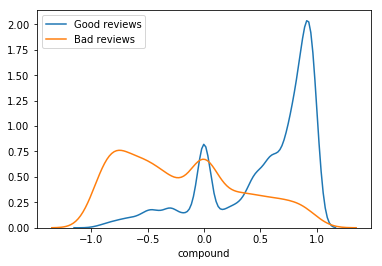

In [30]:
# see the performance of Vader!

import seaborn as sns

for x in [0, 1]:
    subset = reviews_SA[reviews_SA['Bad_Review?'] == x]
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    # plot a univariate distribution of observations
    sns.distplot(subset['compound'], hist = False, label = label)
print("The above graph shows the distribution of the reviews sentiments among good reviews and bad ones. \
We can see that good reviews are for most of them considered as very positive by Vader. On the contrary, \
bad reviews tend to have lower compound sentiment scores.We can see that Vader has a good job \
to find which reviews are good and which ones are bad.")

## Part 3B: Add More Features (second set of features) 

In [31]:
# add column of number of characters and words 
reviews_SA["N_ch"] = reviews_SA["Review"].apply(lambda x: len(x))
# add coulmn of number of words
reviews_SA["N_w"] = reviews_SA["Review"].apply(lambda x: len(x.split(" ")))
reviews_SA.head(3)

,Review,Bad_Review?,Review_clean,compound,neg,neu,pos,N_ch,N_w
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.9924,0.049,0.617,0.334,599,113
274649,No tissue paper box was present at the room,0,tissue paper box present room,-0.2960,0.216,0.784,0.000,44,10
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.6908,0.000,0.345,0.655,36,7


## Part 3D: Word Embedding (Doc2Vec) (third set of features)
In NLP, we often map words into vectors that contains numeric values so that machine can understand it. The aim of word embedding is to redefine the high dimensional word features into low dimensional feature vectors by preserving the contextual similarity in the corpus. They are widely used in deep learning models such as CNN and RNN. Two state-of-the-art word embedding methods are Word2Vec and FastText.

Word2Vec leverages the context of the target words. It is a two-layer neural network that processes text. Its input is a text corpus and its output is a set of vectors: feature vectors for words in that corpus. While Word2vec is not a deep neural network, it turns text into a numerical form that deep networks can understand. It uses the surrounding words to represent the target words with a Neural Network whose hidden layer encodes the word representation. The Word2Vec package from Gensim library creates a numerical vector representation of every word in the corpus by using the contexts in which they appear.

There are two types of Word2Vec: a shallow neural network model called "Continuous Bag of Words" which uses context to predict a target word, and another shallow neural network model called "Skip-gram" which uses a word to predict a target context.
Good ref: https://skymind.ai/wiki/word2vec

Word2Vec


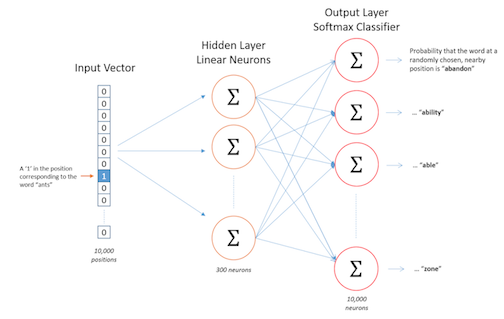

In [32]:
print("Word2Vec")
from IPython.display import Image
Image('/Users/Amir/PythonProjects/HotelRRDataset/skip_gram_net_arch.png')

Continous Bag of Words


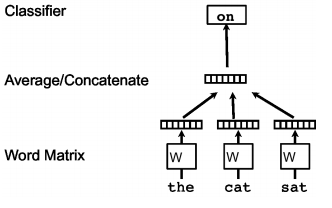

In [33]:
print("Continous Bag of Words")
from IPython.display import Image
Image('/Users/Amir/PythonProjects/HotelRRDataset/CBW.png')


The goal of doc2vec is to create a numeric representation of a document, regardless of its length. But unlike words, documents do not come in logical structures such as words, so the another method has to be found. doc2vec uses word2vec model, and added another vector. 

It is a small extension to the CBOW model. But instead of using just words to predict the next word, we also added another feature vector, which is document-unique.

So, when training the word vectors W, the document vector D is trained as well, and in the end of training, it holds a numeric representation of the document.

The model below is called Distributed Memory version of Paragraph Vector (PV-DM). It acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document.

doc2Vec


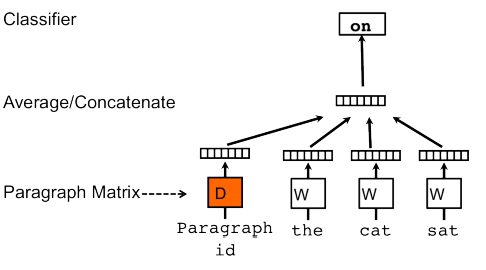

In [34]:
print("doc2Vec")
from IPython.display import Image
Image('/Users/Amir/PythonProjects/HotelRRDataset/doc2vec.png')

In [35]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [37]:
# Make document for doc2vec
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_SA["Review_clean"].apply(lambda x: x.split(" ")))]
# Example of what above syntax produces  
t = reviews_SA.iloc[2:4,2:3]
print(t)
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(t["Review_clean"].apply(lambda x: x.split(" ")))]
documents

                                             Review_clean
374688                        pillow nice welcome service
404352  everything include nice upgrade hotel revamp s...


[TaggedDocument(words=[u'pillow', u'nice', u'welcome', u'service'], tags=[0]),
 TaggedDocument(words=[u'everything', u'include', u'nice', u'upgrade', u'hotel', u'revamp', u'surprise', u'love', u'every', u'second', u'include', u'room', u'dining', u'excellent'], tags=[1])]

In [38]:
# Train a Doc2Vec model with our text data 

# parameters:
# ----> documents- Iterable of list of TaggedDocument
# ----> vector_size- Dimensionality of the feature vectors
# ----> window- The maximum distance between the current and predicted word within a sentence
# ----> min_count- Ignores all words with total frequency lower than this
# ----> workers- Use these many worker threads to train the model (=faster training with multicore machines)
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [39]:
# Transform each document into a vector data
doc2vec_df = reviews_SA["Review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
# add doc2vec results as columns to the dataframes
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_SA = pd.concat([reviews_SA, doc2vec_df], axis=1)

In [32]:
reviews_SA.head(3)

,Review,Bad_Review?,Review_clean,compound,neg,neu,pos,N_ch,N_w,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.9924,0.049,0.617,0.334,599,113,0.049419,0.020219,0.098425,-0.085031,0.025994
274649,No tissue paper box was present at the room,0,tissue paper box present room,-0.2960,0.216,0.784,0.000,44,10,0.086795,0.056118,-0.074711,-0.026259,0.053609
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.6908,0.000,0.345,0.655,36,7,-0.092694,-0.055072,0.068251,0.003932,0.013604


## Part 3D: Statistical Features (TF-IDF) (fourth set of features)
Term Frequency – Inverse Document Frequency (TF – IDF)is a weighted model commonly used for information retrieval problems. It aims to convert the text documents into vector models on the basis of occurrence of words in the documents without taking considering the exact ordering. For Example – let say there is a dataset of N text documents, In any document “D”, TF and IDF will be defined as:
- Term Frequency (TF) – TF for a term “t” is defined as the count of a term “t” in a document “D”
- Inverse Document Frequency (IDF) – IDF for a term is defined as logarithm of ratio of total documents available in the corpus and number of documents containing the term T.
- TF-IDF – formula gives the relative importance of a term in a corpus (list of documents)

But why not simply counting how many times each word appears in every document? The problem with this method is that it doesn't take into account the relative importance of words in the texts. A word that appears in almost every text would not likely bring useful information for analysis. On the contrary, rare words may have a lot more of meanings.

The TF-IDF metric solves this problem:

- TF computes the classic number of times the word appears in the text
- IDF computes the relative importance of this word which depends on how many texts the word can be found

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
# We add TF-IDF columns for every word that appear in at least 10 different texts to filter some of them and 
# reduce the size of the final output.
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_SA["Review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_SA.index
reviews_SA = pd.concat([reviews_SA, tfidf_df], axis=1)

In [42]:
reviews_SA.head(3)

,Review,Bad_Review?,Review_clean,compound,neg,neu,pos,N_ch,N_w,doc2vec_vector_0,...,word_yet,word_yoghurt,word_yogurt,word_young,word_yr,word_yummy,word_zero,word_ziggo,word_zone,word_zuid
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.9924,0.049,0.617,0.334,599,113,0.049419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274649,No tissue paper box was present at the room,0,tissue paper box present room,-0.2960,0.216,0.784,0.000,44,10,0.086795,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.6908,0.000,0.345,0.655,36,7,-0.092694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Part 4: Review Sentiment Prediction

First, choose which features we want to use to train our model. 

Second, split our data into two parts:
- one to train our model
- one to assess its performances

Third, use a Random Forest (RF) classifier for our predictions.

## Part 4A: Feature Selection

First, choose which features we want to use to train our model. 

In [43]:
no_feature = ['Bad_Review?','Review', 'Review_clean']
features = [c for c in reviews_SA.columns if c not in no_feature]
reviews_SAX = reviews_SA[features]
reviews_SAY= reviews_SA['Bad_Review?']
reviews_SAX.head(3)
#reviews_SAY.head(3)

,compound,neg,neu,pos,N_ch,N_w,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,...,word_yet,word_yoghurt,word_yogurt,word_young,word_yr,word_yummy,word_zero,word_ziggo,word_zone,word_zuid
488440,0.9924,0.049,0.617,0.334,599,113,0.049419,0.020219,0.098425,-0.085031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274649,-0.2960,0.216,0.784,0.000,44,10,0.086795,0.056118,-0.074711,-0.026259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374688,0.6908,0.000,0.345,0.655,36,7,-0.092694,-0.055072,0.068251,0.003932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
print(len(features))
features[1:20]

3837


['neg',
 'neu',
 'pos',
 'N_ch',
 'N_w',
 'doc2vec_vector_0',
 'doc2vec_vector_1',
 'doc2vec_vector_2',
 'doc2vec_vector_3',
 'doc2vec_vector_4',
 'word_abbey',
 'word_ability',
 'word_abit',
 'word_able',
 'word_abroad',
 'word_abrupt',
 'word_absence',
 'word_absolute',
 'word_absolutely']

In [45]:
len(reviews_SA.columns)

3840

In [46]:
reviews_SAX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51574 entries, 488440 to 273809
Columns: 3837 entries, compound to word_zuid
dtypes: float32(5), float64(3830), int64(2)
memory usage: 1.5 GB


## Part 4B: Train the Model using Random Forest 

Second, split our data into two parts:

- one to train our model
- one to assess its performances

Third, we use Random Forest(RF) classifier to cladssfiy reviews into positive and negative classes. 
RF is a supervised learning algorithm. It creates a forest and makes it somehow random. The "forest" it builds, is an ensemble of Decision Trees. The more trees it has, the more robust a forest is. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance.

Advantages:
- It does not suffer from the overfitting problem. The main reason is that it takes the average of all the predictions, which cancels out the biases.
- Random forests is considered as a highly accurate and robust method because of the number of decision trees participating in the process

Good ref: https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd

Random Forest Classifier


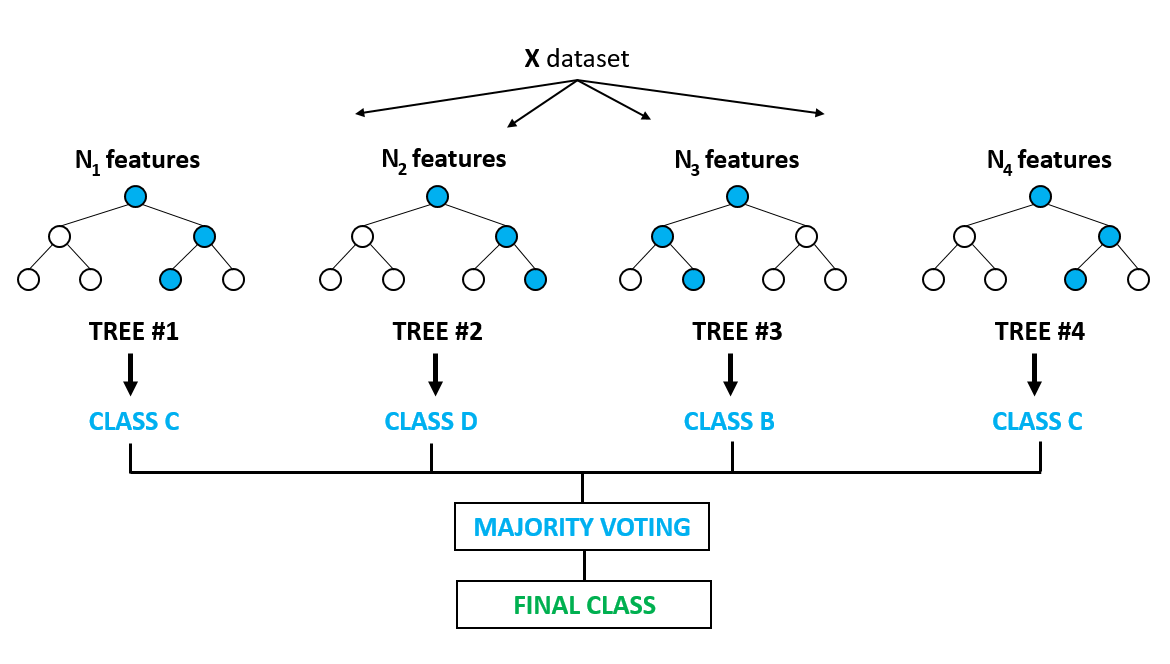

In [48]:
print("Random Forest Classifier")
from IPython.display import Image
Image('/Users/Amir/PythonProjects/HotelRRDataset/RF.png')

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# creat taring and test datasets (80% and 20%)
X_train, X_test, y_train, y_test = train_test_split(reviews_SAX, reviews_SAY, test_size = 0.20, random_state = 42)

# train a random forest classifier
# n_estimators hyperparameter is just the number of trees the algorithm builds before taking the maximum voting 
# or taking averages of predictions. A higher number increases the performance and makes the predictions more stable, 
# but it also slows down the computation
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Part 4C: Find Important Features
We want to know which features are important to predict sentiments. A great quality of the random forest algorithm is that it is very easy to measure the relative importance of each feature on the prediction. 

Sklearn provides a great tool to measures a features importance by looking at how much the tree nodes, which use that feature, reduce impurity across all trees in the forest. It computes this score automatically for each feature after training and scales the results, so that the sum of all importance is equal to 1.

In [62]:
feature_imp = pd.DataFrame({'Feature':features, 'Importance': rf.feature_importances_}).sort_values('Importance', ascending = False)
key_features = feature_imp.head(20)
key_features


,Feature,Importance
0,compound,0.039506
3,pos,0.024446
1,neg,0.022683
4,N_ch,0.018442
2,neu,0.016446
6,doc2vec_vector_0,0.016359
5,N_w,0.015373
8,doc2vec_vector_2,0.015221
10,doc2vec_vector_4,0.015191
7,doc2vec_vector_1,0.014691


/anaconda3/anaconda3/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


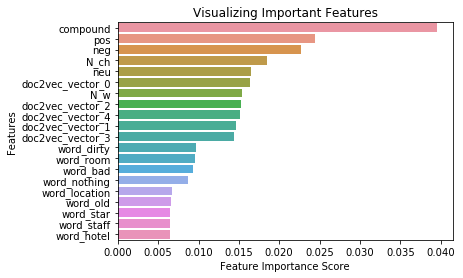

In [65]:
# Visulaize important feature 
# Creating a bar plot
sns.barplot(x=key_features['Importance'], y=key_features['Feature'])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()

In [49]:
print("The most important features are indeed the ones that come from the previous sentiment analysis. \
The vector representations of the texts also have a lot of importance in our training. \
Some words appear to have a fairly good importance as well.")

The most important features are indeed the ones that come from the previous sentiment analysis. The vector representations of the texts also have a lot of importance in our training. Some words appear to have a fairly good importance as well.


## Part 5: Predicition Quality


## Part 5A: Classifier Accuracy


In [88]:
# Calculating accurcy using test dataset
y_prediction=rf.predict(X_test)
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_prediction))

('Accuracy:', 0.9562772661173049)


## Part 5B: AUC PR (Area Under the Curve Precision Recall)

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision. A balance of these two concerns can be chosen by the operator of the model.
High precision relates to a low false positive rate (Predict an event when there was no event), and high recall relates to a low false negative rate (Predict no event when in fact there was an event.)


In [89]:
from sklearn.metrics import average_precision_score

y_pred = [x[1] for x in rf.predict_proba(X_test)]

# calculate precision

# Precision is defined as the number of true positives divided to the number of true positives 
# plus the number of false positives.
# average_precision_score function summarizes a precision-recall curve as the weighted mean of precisions achieved 
# at each threshold, with the increase in recall from the previous threshold used as the weight
average_precision = average_precision_score(y_test, y_pred)
print('Average precision score: {0:0.2f}'.format(average_precision))

Average precision score: 0.36


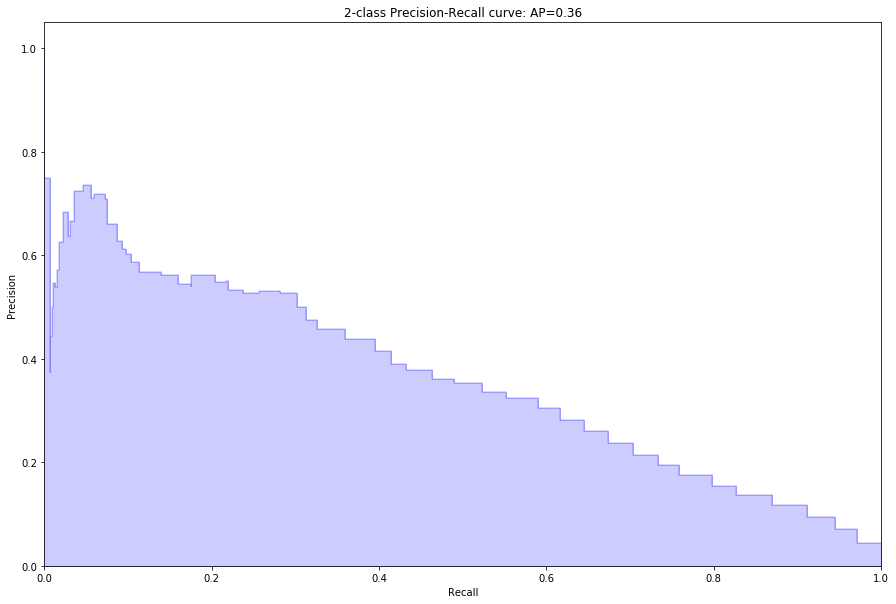

In [91]:
# Plot the Precision-Recall curve
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.utils.fixes import signature

# Recall is defined as the number of true positives divided to the number of true positives 
# plus the number of false negatives.
precision, recall, _ = precision_recall_curve(y_test, y_pred)

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [3]:
from sklearn.metrics import f1_score
f_one =f1_score(y_test, y_pred)
f_one

NameError: name 'y_test' is not defined